<a href="https://colab.research.google.com/github/joshualin24/Lens_Finder/blob/master/ViT_attention_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install transformers


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import cv2
import numpy as np
import scipy as sp
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from  torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
import numpy as np
import os
import time
import astropy.io.fits as pyfits
import sys
import argparse
from tqdm import tqdm
import pandas as pd
import gc
import scipy.ndimage
import datetime
# vision transformer
from transformers import ViTModel, ViTConfig, ViTFeatureExtractor, ViTForImageClassification

In [13]:
"""
Create ViT
"""
## Vision Transformer
net = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# change the last layer
net.classifier = nn.Linear(in_features=768, out_features=18, bias=True)

print("Number of trainable parameters: {}".format(sum(param.numel() for param in net.parameters() if param.requires_grad)))

"""
Load Pretrained Weights (net 010822B)
"""
net = torch.load('/content/epoch_13_testloss_0.328027.mdl')

Number of trainable parameters: 85812498


In [137]:
def vit_attention_map_randomBatch(model, data_loader, device):
    """
    Extract the attention map of ViT from random sampled images
    Args:
        model: vit model
        data_loader: train/validation/test data loader
        df: the dataframe containing the true/predicted labels
        device: gpu or cpu
    """
    # move to gpu
    model = model.to(device)
    # evaluation
    model.eval()

    ### visualization parameters
    alpha = 1
    beta = 0.1
    gamma = 0.1


    # # galaxy categories
    # gxy_labels = ['Round Elliptical', 'In-between Elliptical','Cigar-shaped Elliptical',
    #               'Edge-on Spiral','Barred Spiral','Unbarred Spiral','Irregular','Merger']
    
    for images, target_res in data_loader:
        images = images.to(device)
        images = images.float()
        with torch.no_grad():
            return_dict = model.config.use_return_dict
            outputs = model.vit(images, output_attentions=True, output_hidden_states=True, return_dict=return_dict)

            fig, axs = plt.subplots(14, 8, figsize=(20, 30))
            for idx in range(images.cpu().numpy().shape[0]):
                if idx >= 8:
                    break
                # image (need to convert to cv2 format)
                img = images[idx].cpu().numpy()
                img /= np.amax(img)
                img *= 10
                #img += 0.5
                img = np.transpose(img, (1, 2, 0))  # (224, 224, 3)
                sample_img = img * 0.5
                img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#                 # galaxy ID
#                 gal_id = galaxy_id[idx].cpu().numpy()
#                 # y_true
#                 y_true = gxy_labels[df[df['GalaxyID']==gal_id]['class'].values[0]]
#                 # y_pred
#                 y_pred = gxy_labels[df[df['GalaxyID']==gal_id]['pred'].values[0]]

                
                axs[0][idx].imshow(sample_img)
                #axs[0][idx].set_title("ID:{}\nClass: {}\nPred: {}".format(gal_id, y_true, y_pred), fontsize=10)
                axs[0][idx].axis('off')

                # attention averaged over all heads
                attn_matrices = []
                for layer_i in range(12):
                    # average all heads
                    attn = np.mean(outputs[2][layer_i][idx].cpu().numpy(), axis=0)  # (197, 197)
                    # add residual
                    attn += np.identity(attn.shape[0])  # (197, 197)
                    # normalize
                    attn = attn/2  # (197, 197)
                    # recurvie multiply the attention matrices
                    if layer_i != 0:
                        attn = np.matmul(attn, attn_matrices[layer_i-1])
                    # append to list
                    attn_matrices.append(attn)
                    # attn map
                    attn_map = np.array(attn[0, 1:]).reshape(14, 14)
                    # normalize
                    attn_map = attn_map / attn_map.max()
                                        # attn mask
                    attn_mask = cv2.resize(attn_map, (224, 224))[..., None]
                    attn_mask = np.concatenate((attn_mask, attn_mask, attn_mask), axis=2)
                    attn_mask = alpha * attn_mask + beta * (attn_mask*img) + gamma * img
                    
                    
                    
                axs[1, idx].imshow(attn_mask[..., 0], cmap='jet')
                axs[1, idx].set_title("Attn (avg)", fontsize=10)
                axs[1, idx].axis('off')


                ## attention of individual heads
                head_attn_matrices = [[] for _ in range(12)]
                for h_idx in range(12):
                    for layer_i in range(12):
                        # individual head
                        attn = outputs[2][layer_i][idx].cpu().numpy()[h_idx]  # (197, 197)
                        # add residual
                        attn += np.identity(attn.shape[0])  # (197, 197)
                        # normalize
                        attn = attn/2  # (197, 197)
                        # recurvie multiply the attention matrices
                        if layer_i != 0:
                            attn = np.matmul(attn, head_attn_matrices[h_idx][layer_i-1])
                        # append to list
                        head_attn_matrices[h_idx].append(attn)
                    # attn map
                    attn_map = np.array(attn[0, 1:]).reshape(14, 14)
                    # normalize
                    attn_map = attn_map / attn_map.max()
                    # attn mask
                    attn_mask = cv2.resize(attn_map, (224, 224))[..., None]
                    attn_mask = np.concatenate((attn_mask, attn_mask, attn_mask), axis=2)
                    attn_mask = alpha * attn_mask + beta * (attn_mask*img) + gamma * img


                    

                    axs[2+h_idx, idx].imshow(attn_mask[..., 0], cmap='jet')
                    axs[2+h_idx, idx].set_title("Head #{}".format(1+h_idx), fontsize=10)
                    axs[2+h_idx, idx].axis('off')

        plt.show()
        break

In [138]:
class DeepLenstronomyDataset(Dataset):  # torch.utils.data.Dataset

    def __init__(self, root_dir, use_train=True, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.use_train = use_train  # training set or test set
        self.train_folder = ''
        self.test_folder = ''

        if self.use_train:
            self.path = Path(f"{self.root_dir}/{self.train_folder}")
        else:
            self.path = Path(f"{self.root_dir}/{self.test_folder}")
        # self.df = pd.read_csv(Path(f"{self.path}/metadata_test.csv"))
        # self.df = self.df.head(9)
        self.df = sample_df

    def __getitem__(self, index):
        img_name = self.df['img_path'].values[index][-13:]  #TODO: this is hard coded
        img_path = Path(f"{self.path}/{img_name}")
        img = np.load(img_path)
        img = scipy.ndimage.zoom(img, 224 / img.shape[0], order=1)  #TODO: this is hard coded
        print('img info', img_name)
        image = np.zeros((3, 224, 224))  #TODO: this is hard coded
        for i in range(3):
            image[i, :, :] += img

        # target_keys = [
        #     "theta_E",
        #     "gamma",
        #     "center_x",
        #     "center_y",
        #     "e1",
        #     "e2",
        #     "source_x",
        #     "source_y",
        #     "gamma_ext",
        #     "psi_ext",
        #     "source_R_sersic",
        #     "source_n_sersic",
        #     "sersic_source_e1",
        #     "sersic_source_e2",
        # ]
        # target_res = {key: self.df[key].iloc[[index]].values for key in target_keys}
        _ = '_'
        return image, _#, target_res

    def __len__(self):
        return self.df.shape[0]

In [139]:

def get_train_test_datasets(dataset_folder):
    data_transform = transforms.Compose([
        transforms.ToTensor(), # scale to [0,1] and convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    target_transform = torch.Tensor

    train_dataset = DeepLenstronomyDataset(
        dataset_folder,
        use_train=True,
        transform=data_transform,
        target_transform=target_transform,
    )
    test_dataset = DeepLenstronomyDataset(
        dataset_folder,
        use_train=False,
        transform=data_transform,
        target_transform=target_transform,
    )
    return train_dataset, test_dataset


def get_train_test_dataloaders(batch_size, train_dataset, test_dataset):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
    )
    return train_loader, test_loader


def prepare_data_and_target(data, target_dict, device):
    data = Variable(data.float()).to(device)
    for key, val in target_dict.items():
        target_dict[key] = Variable(val.float()).to(device)
    target = torch.cat([val for _, val in target_dict.items()], dim=1)
    return data, target



In [140]:
CONFIG = {
    'batch_size': 8,
    'dataset_folder': Path("/content/drive/MyDrive/Lens_vit_file/dev_256/"),
    'dir_model_save': Path("/content/drive/MyDrive/")
}

#%cd /content/drive/MyDrive/
train_dataset, test_dataset = get_train_test_datasets(CONFIG['dataset_folder'])
train_loader, test_loader = get_train_test_dataloaders(CONFIG['batch_size'], train_dataset, test_dataset)

img info X_0020398.npy
img info X_0023833.npy
img info X_0024836.npy
img info X_0024572.npy
img info X_0002545.npy
img info X_0001161.npy
img info X_0004070.npy
img info X_0004682.npy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


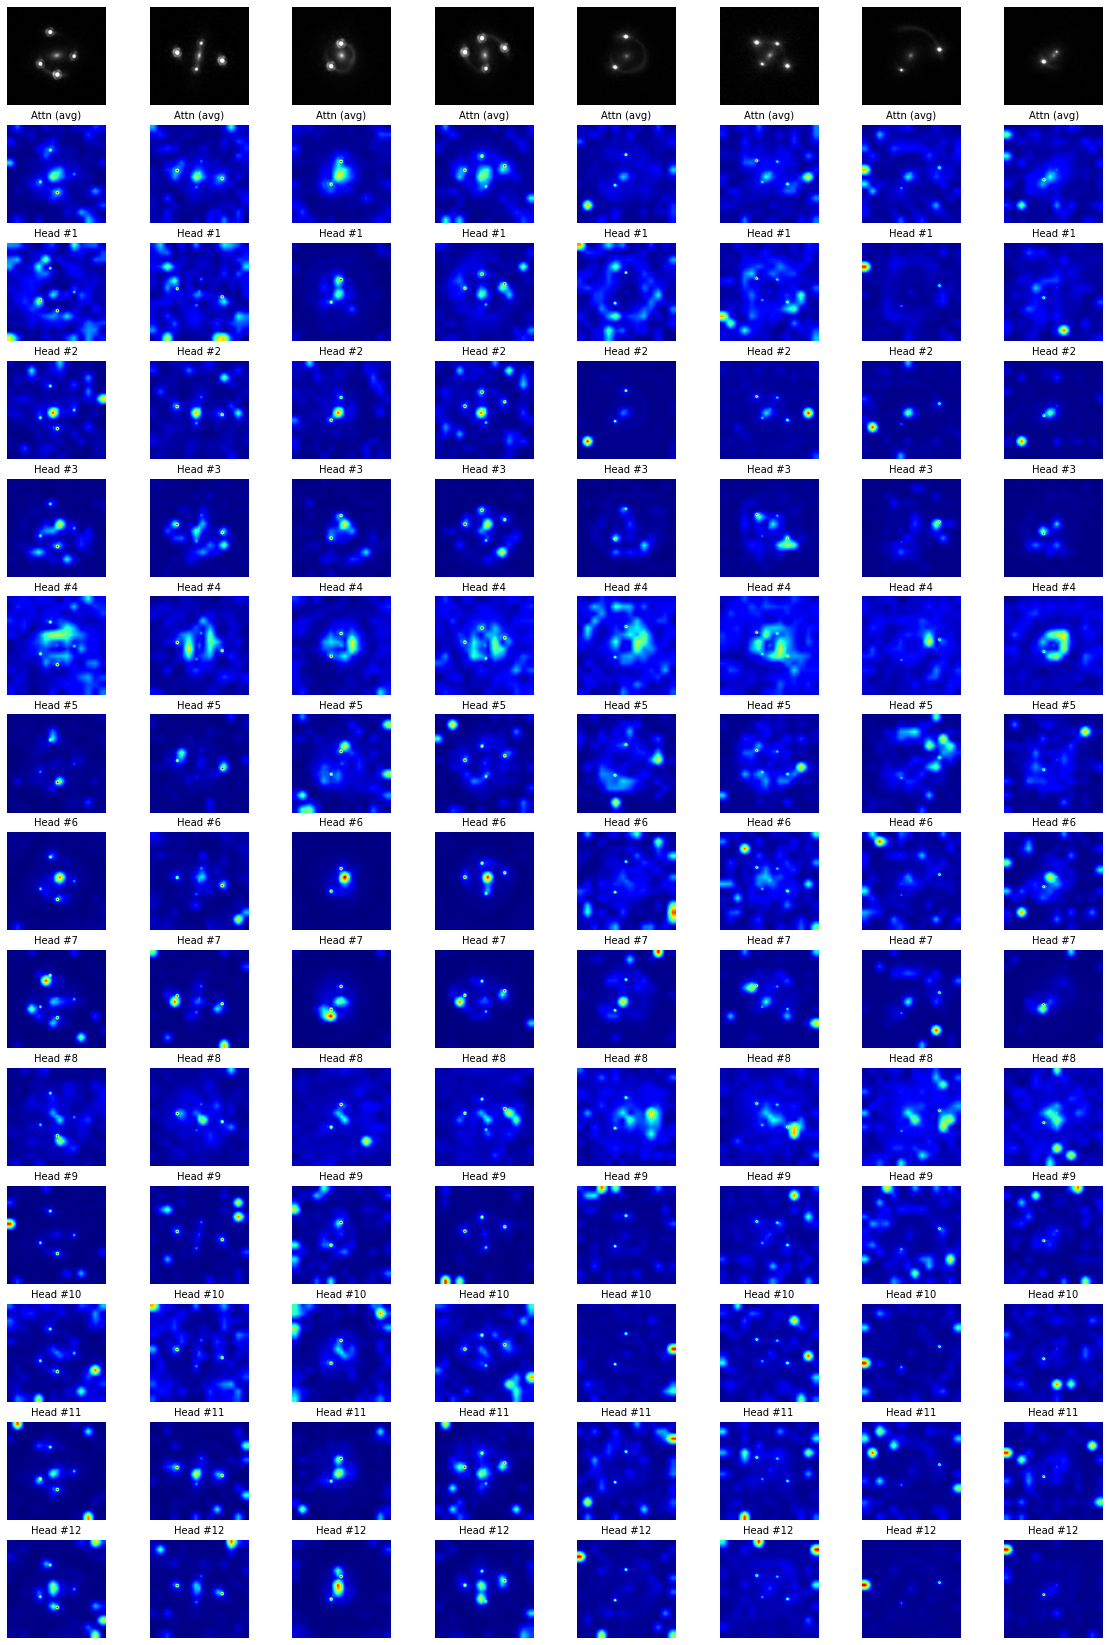

In [141]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vit_attention_map_randomBatch(net, test_loader, device)

In [135]:
test_file = pd.read_csv('./metadata_test.csv')

In [136]:
for i in range(10):
  file_path = test_file['img_path'][i+6]
  file_path = file_path[:23] + 'Lens_vit_file' + file_path[39:]
  print(file_path)
  #%cp file_path '/content/'

/content/drive/MyDrive/Lens_vit_file/dev_256/X_0001161.npy
/content/drive/MyDrive/Lens_vit_file/dev_256/X_0002230.npy
/content/drive/MyDrive/Lens_vit_file/dev_256/X_0000148.npy
/content/drive/MyDrive/Lens_vit_file/dev_256/X_0002530.npy
/content/drive/MyDrive/Lens_vit_file/dev_256/X_0004070.npy
/content/drive/MyDrive/Lens_vit_file/dev_256/X_0001261.npy
/content/drive/MyDrive/Lens_vit_file/dev_256/X_0004682.npy
/content/drive/MyDrive/Lens_vit_file/dev_256/X_0000333.npy
/content/drive/MyDrive/Lens_vit_file/dev_256/X_0000906.npy
/content/drive/MyDrive/Lens_vit_file/dev_256/X_0003170.npy


In [130]:
sample_df = pd.DataFrame()

sample_df['img_path'] = ['X_0020398.npy', 'X_0023833.npy', 'X_0024836.npy', 'X_0024572.npy', 'X_0002545.npy', 'X_0001161.npy', 'X_0004070.npy', 'X_0004682.npy']

sample_df

,img_path
0,X_0020398.npy
1,X_0023833.npy
2,X_0024836.npy
3,X_0024572.npy
4,X_0002545.npy
5,X_0001161.npy
6,X_0004070.npy
7,X_0004682.npy
